# Pt 1. gmx clustering

The idea here is that you can choose a histogram that you are interested in, and from here we will run `gmx_cluster` and then parse the results that are outputted

In [1]:
import numpy as np
from os.path import exists
import pandas as pd
import matplotlib.pyplot as plt

import MDAnalysis as mda
import MDAnalysis.analysis.distances as d
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [2]:
extent = np.load('../../string_sims/TMD_initial_path/influx_BFRU_gate_CV/extent_MSM.npy')
F = np.load('../../string_sims/TMD_initial_path/influx_BFRU_gate_CV/F_MSM.npy')

In [3]:
indir = '../textfiles_out/gmx_cluster_files'

def cluster_overview(histogram, min_number_members_in_clu = 2, which_percent = 'significant'):
    
    if exists(f"{indir}/histogram_{histogram}/clust-id.xvg"):
        
        clust_id = np.loadtxt(f"{indir}/histogram_{histogram}/clust-id.xvg")
        #f = open(f"{indir}/histogram_{histogram}/cluster.log").read().splitlines()

        (cluster_labels, number_members) = np.unique(clust_id[:,1], return_counts=True)
        cluster_labels = cluster_labels[np.where(number_members > min_number_members_in_clu)]
        number_members = number_members[np.where(number_members > min_number_members_in_clu)]


        ## get the percentage of the numbers
        if which_percent == 'significant':
            percentage_of_total = np.round(number_members / sum(number_members) * 100, 2)
        elif which_percent == 'all':
            percentage_of_total = np.round(number_members / len(clust_id) * 100, 2)

            
        cluster_labels = [f"cluster {int(m)}" for m in cluster_labels]
        

        #cluster_overview = dict(zip(cluster_labels, percentage_of_total))
        cluster_overview = {}
        cluster_overview['cluster_labels'] = cluster_labels
        cluster_overview['percentage_of_total'] = percentage_of_total
        cluster_overview['total_frames'] = len(clust_id)
        cluster_overview['total_sig_frames'] = sum(number_members)
        cluster_overview['mean_percentage'] = np.round(np.mean(percentage_of_total), 3)
        cluster_overview['std_percentage'] = np.round(np.std(percentage_of_total), 3)
        cluster_overview['n_clusters'] = len(percentage_of_total)

        
        if len(percentage_of_total) == 0:
            cluster_overview['max_percentage'] = 0
        else:
            cluster_overview['max_percentage'] = np.max(percentage_of_total)


    
    else:
        #print(f'histogram {histogram} has no confout files, skipping...')
        cluster_overview = {'cluster_labels':'none', 'percentage_of_total': 0, 'total_frames': 0, \
                            'total_sig_frames': 0, 'max_percentage':0, 'mean_percentage':0,\
                           'std_percentage': 0, 'n_clusters' : 0}
    
    cluster_overview['histogram'] = histogram
    return cluster_overview

Make a pandas dataframe with the results from above

We will reindex on histogram #, and then also cut away anything with less than 500 total frames, so we get good sampling

In [4]:
#pd.set_option('display.max_rows', None)
### 2500 is how many histograms we calculated for for now, but I am trying something out....

cluster_info = []
max_histo_index = 2916
for x in range(0,max_histo_index):
    cluster_info.append(cluster_overview(x))

cluster_info_df = pd.DataFrame(cluster_info)
cluster_info_df = cluster_info_df.set_index('histogram')

cluster_info_df

/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret =

,cluster_labels,percentage_of_total,total_frames,total_sig_frames,max_percentage,mean_percentage,std_percentage,n_clusters
histogram,,,,,,,,
0,none,0,0,0,0.0,0.0,0.0,0
1,none,0,0,0,0.0,0.0,0.0,0
2,none,0,0,0,0.0,0.0,0.0,0
3,none,0,0,0,0.0,0.0,0.0,0
4,none,0,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...
2911,none,0,0,0,0.0,0.0,0.0,0
2912,none,0,0,0,0.0,0.0,0.0,0
2913,none,0,0,0,0.0,0.0,0.0,0


In [5]:
sig_cluster_histos = list(cluster_info_df.index)
num = 54
test_G = np.empty((num, num))
test_G[:] = np.NaN


row_index = 0
col_index = 0
for histo_index in sig_cluster_histos:    
    ## start over the row and cols at 55, going l --> r, bottom to top
    if histo_index % num == 0 and histo_index != 0:
        row_index = row_index + 1
        col_index = 0

    #print(row_index, col_index)  
    score = (cluster_info_df.loc[histo_index, 'max_percentage'])
    #print(score, histo_index)
    if score != 0:
        test_G[row_index, col_index] = score
    
    col_index = col_index + 1
    
print(test_G[40])

[   nan    nan    nan    nan    nan  62.5   47.86  34.97  31.07  27.03
  38.37  27.03  42.2   66.39 100.   100.      nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan]


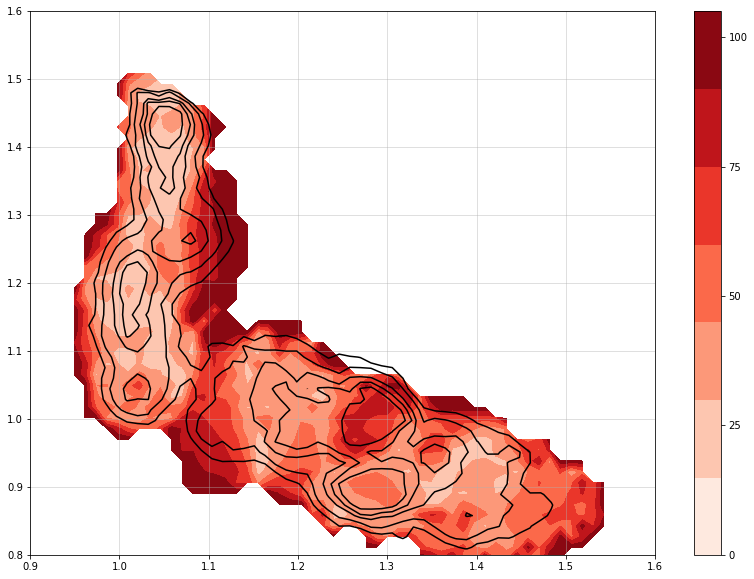

In [6]:
%matplotlib inline

f = plt.figure(figsize = (14,10))
ax = f.add_subplot(111)

color_levels = 5
score_contour = ax.contourf(test_G, extent = extent, cmap=plt.cm.Reds, levels = color_levels)
cbar_ticks = np.linspace(0, np.nanmax(test_G), color_levels, dtype = int)
cbar = f.colorbar(score_contour, ticks = cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticks)


## contour on top of F
## you can choose what FES levels to add by changing levels below
line_levels = [0, 1, 1.5, 2, 3, 4]
FES_contour = ax.contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black',)



plt.grid(which='major', alpha=0.5)
xlim = (0.9,1.6)
ylim = (0.8,1.6)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Pt. 2 - looking at trajectories of `clusters.pdb`



### Pipeline
1. Find where in the `cluster_info_df` is the highest percentage per histogram (currently, could change to something else easily) and then take the index of this to get the corresponding cluster label. These cluster labels are written `'cluster n'` so we have to split them by whitespace, and then take the `n - 1` as `cluster 1` is in the 0th position
- In MDAnalysis, it seems enough to just call `clusters.trajectory[n]` to update the trajectory to this coordinate, where you can do your processing on this. **please** double check that this is correct with looking in Pymol before coming to any major conclusions

2. Run `hbond` analysis from MDA
3. Find closest members to each OH group, and their Hbonding partners, using `find_OH_group_in_hbonds_results`

In [7]:
def find_OH_group_in_hbonds_results(OH_atomnames, hbonds_results):
    
    for h_bond in hbonds_results.results.hbonds:
        frame, donor_index, hydrogen_index, acceptor_index = h_bond[:4].astype(int)
        
        #first define actual members of each h bond group
        sugar_hbonds = clusters.atoms[[donor_index, acceptor_index]]

        # then find if there is a match for the atomname. Then remove sugar from that list
        if any(atom_n in OH_atomnames for atom_n in sugar_hbonds.names):
            matching_OH_hbond = [f'{resn}:{resi}' for resn,resi in zip(sugar_hbonds.residues.resnames, sugar_hbonds.residues.resids)]
            matching_OH_hbond.remove('BFRU:475')
            return matching_OH_hbond

Results shape of hbonds: 
- **0 frame** : frame at which a hydrogen bond was found
- **1 donor id** : atom id of the hydrogen bond donor atom
- **2 hydrogen** id : atom id of the hydrogen bond hydrogen atom
- **3 acceptor** id : atom id of the hydrogen bond acceptor atom
- **4 distance** (Å): length of the hydrogen bond
- **5 angle** (degrees): angle of the hydrogen bond

In [8]:
run_OH_calculation = False

In [9]:
if run_OH_calculation:
    OH_close_partners_all_dicts = []
    OH_h_bonds_all_dicts = []
    relevant_histograms = []

    for histogram in range(0, max_histo_index):
        if exists(f"{indir}/histogram_{histogram}/clusters.pdb"):
            print(f"histogram {histogram} exists, processing... ")

            ##### 
            ## Pt 1 - loading clusters.pdb and getting correct traj index
            clusters = mda.Universe('../confout_files/tpr_files/influx_BFRU_gate_CV.protonly.tpr',\
                                    f"{indir}/histogram_{histogram}/clusters.pdb")

            if len(cluster_info_df.loc[histogram, 'percentage_of_total']) > 0:
                cluster_ID = np.array(cluster_info_df.loc[histogram, 'cluster_labels'])
                percentage = list(cluster_info_df.loc[histogram, 'percentage_of_total'])
                max_cluster_index = int(cluster_ID[np.argmax(percentage)].split(' ')[1]) - 1 #need Python indexing
                clusters.trajectory[max_cluster_index]

                relevant_histograms.append(histogram)

                ####### 
                ### Pt 2 - run MDA hbond analysis
                hbonds = HBA(universe=clusters, between=['protein', 'resname BFRU'])
                hbonds.run(start=max_cluster_index, stop=(max_cluster_index+1))




                ####### 
                ### Pt 3. get information for each OH group into 2 dicts
                ## O5 is the linker oxygen, so no H bonding and no H for him either
                fructose_OH = {'OH1':['O1', 'HO1'], 'OH2':['O2', 'HO2'], \
                               'OH3':['O3', 'HO3'], 'OH4':['O4', 'HO4'], \
                               'OH6':['O6', 'HO6'], }

                each_OH_close_partners = {}
                each_OH_h_bonds = {}

                dist_cutoff = 3.5
                for title, atoms in fructose_OH.items():
                    clusters.trajectory[max_cluster_index]

                    # selections
                    OH = clusters.select_atoms(f'resname BFRU and name {atoms[0]} {atoms[1]}')
                    close_res = clusters.select_atoms(f'not resname BFRU and around {dist_cutoff} resname BFRU and name {atoms[0]} {atoms[1]}')

                    # find close partners
                    each_OH_close_partners[title] = [f'{resn}:{resi}' for resn,resi in zip(close_res.residues.resnames, close_res.residues.resids)]

                    # find h bonding partners
                    each_OH_h_bonds[title] = find_OH_group_in_hbonds_results(atoms, hbonds)


                # check that these dicts match
                for k, v in each_OH_h_bonds.items():
                    if v:  #skip OH hbonds that aren't empty, which is most
                        if not any(x in v for x in each_OH_close_partners[k]): ## if any item of hbonds is not in close partners, yell
                            print(f'WARNING, no match in hbond to close partners for histogram {histogram}, {k}, : {v}')
                            print()

                OH_close_partners_all_dicts.append(each_OH_close_partners)
                OH_h_bonds_all_dicts.append(each_OH_h_bonds)
    
    
    # put dicts together to df
    OH_close_partners_all_dicts = pd.DataFrame(OH_close_partners_all_dicts, index=relevant_histograms)
    OH_h_bonds_all_dicts = pd.DataFrame(OH_h_bonds_all_dicts, index=relevant_histograms)
    OH_h_bonds_all_dicts.columns = [f'hbond_{x}' for x in OH_h_bonds_all_dicts.columns]
    OH_close_partners_all_dicts.columns = [f'nearby_{x}' for x in OH_close_partners_all_dicts.columns]
    sugar_OH_intxns = pd.concat([OH_close_partners_all_dicts, OH_h_bonds_all_dicts], axis = 1)

    
    # put sugar_OH and cluster info dfs together
    column_names = sugar_OH_intxns.columns
    column_names = sorted(column_names, key=lambda x: int(x[-1]))
    sugar_OH_intxns = sugar_OH_intxns.reindex(columns=column_names)
    sugar_OH_intxns.index.name = 'histogram'
    cluster_and_OH_info_df = pd.concat([cluster_info_df, sugar_OH_intxns], axis = 1)
    
    # save!
    pd.to_pickle(cluster_and_OH_info_df, '../textfiles_out/gmx_cluster_files/cluster_and_OH_info_df.pkl')
    

else:
    cluster_and_OH_info_df = pd.read_pickle('../textfiles_out/gmx_cluster_files/cluster_and_OH_info_df.pkl')
    

## scoring based on H bonding or whatever properties you want to, using both `sugar_OH_intxns` and `cluster_info_df`

In [10]:
def scoring_functions(score_choice, histo_index, frames_filter = 0, hbond_score_dict=None, particular_sel = None):
    n_frames = cluster_and_OH_info_df.loc[histo_index, 'total_frames']
    
    
    if n_frames > frames_filter:
        
        #############################
        ## score choice pct_hbond: ##
        #############################
        if score_choice == 'pct_hbond':
            score_max_pct = cluster_and_OH_info_df.loc[histo_index, 'max_percentage']
            
            # will get an error if hbond list is [nan,nan...] so only take valus which we have hbonds possible
            if score_max_pct > 0:
                score_hbond  = np.array(cluster_and_OH_info_df.loc[histo_index, ['hbond_OH1', 'hbond_OH2', 'hbond_OH3', 'hbond_OH4', 'hbond_OH6']])
                score_hbond  = score_hbond[score_hbond!=np.array(None)]
                score_hbond  = [list(f) for f in score_hbond]
                score_hbond  = len(score_hbond)   
            else:
                score_hbond = 0 

            if score_max_pct != 0 and score_hbond == 0:
                scoring_function_out = score_max_pct
            elif score_max_pct != 0 and score_hbond != 0:
                scoring_function_out = score_max_pct * score_hbond 
            else:
                scoring_function_out = np.nan

        
    
    
    
        #############################
        ## score choice pct_only: ##
        #############################
        elif score_choice == 'pct_only':
            scoring_function_out = cluster_and_OH_info_df.loc[histo_index, 'max_percentage']
    
    
    
    
        #############################
        ## score choice hbonds_only: ##
        #############################
        if score_choice == 'hbond_only':
            score_max_pct = cluster_and_OH_info_df.loc[histo_index, 'max_percentage']
            
            # will get an error if hbond list is [nan,nan...] so only take valus which we have hbonds possible
            if score_max_pct > 0:
                score_hbond  = np.array(cluster_and_OH_info_df.loc[histo_index, ['hbond_OH1', 'hbond_OH2', 'hbond_OH3', 'hbond_OH4', 'hbond_OH6']])
                score_hbond  = score_hbond[score_hbond!=np.array(None)]
                score_hbond  = [list(f) for f in score_hbond]
                score_hbond  = len(score_hbond)   


            if score_max_pct != 0 and score_hbond == 0:
                scoring_function_out = np.nan
            elif score_max_pct != 0 and score_hbond != 0:
                scoring_function_out = score_hbond 
            else:
                scoring_function_out = np.nan

        
    
        
      
    
    
        #########################################
        ### score choice hbond_to_binding_site ## 
        #########################################
        ## here I want to add N287, S385, Q160, h bonds (or close contacts)
        ### and then each histo gets assigned a color based on their interactor (ex green for N287)
        ## you can do this by giving them a 'score' and each 'score' gets a color using qualitative cmaps
        ## in matplotlib depending on if they are doing h-bonding to one (or more) of those residues. Then
        ## we should be able to see the path somewhat clearly
        
        elif score_choice == 'hbond_to_binding_site':
           # hbonds = np.array(cluster_and_OH_info_df.loc[histo_index, ['hbond_OH1', 'hbond_OH2', 'hbond_OH3', 'hbond_OH4', 'hbond_OH6']])
            hbonds = np.array(cluster_and_OH_info_df.loc[histo_index, [particular_sel]]) 
            hbonds = list(hbonds[hbonds!=None])
            hbonds = np.ravel(hbonds)
            
            
            ## TO DO - this is NOT FINISHED!!!!!!!!!!! add more binding site residues, also wtf should I do with 
            ### double h bonds??? How to not get overlapping score? 
            scoring_function_out = np.nan
            for hbond in hbonds:
                if hbond in hbond_score_dict.keys():
                    scoring_function_out = hbond_score_dict[hbond]
            #print(hbonds, scoring_function_out, particular_sel)
    
    
       
        
        
        
        
         ############################################
        ### score choice nearby_particular_residue ## 
        ############################################ 
           
        ### the idea here is that I would color by OH group, depending on if it is close to a certain
        ## residue or not!!!! (ex: for N287, if OH1 is closest, be green, if OH2 is close, be blue...)
        
        
        elif score_choice == 'nearby_particular_residue':
            nearby = np.array(cluster_and_OH_info_df.loc[histo_index, list(hbond_score_dict.keys())]) 
            nearby = list(nearby[nearby!=None])
            nearby = np.ravel(nearby)

            
            ## nearby is a list 5 elements long, one per OH group column in DF
            repeat_counter = 0
            for n, oh_group in enumerate(nearby):
                if particular_sel in oh_group:
                    repeat_counter = repeat_counter + 1
                    scoring_function_out = n+1 ## n is zero index, want 1-5   
               
            # if you have multiple of your selection, give this a new number, otherwise keep it the same
            ## or if it never shows up, give it nan
            if repeat_counter > 1 and scoring_function_out == 2:  #when res near OH 1&2
                scoring_function_out = 6
            elif repeat_counter > 1:   #when res over everywhere
                scoring_function_out = 7
            elif repeat_counter == 1:
                scoring_function_out = scoring_function_out
            elif repeat_counter == 0:
                scoring_function_out = np.nan
            
        #print(histo_index, 'score: ', scoring_function_out, 'rep ', repeat_counter, particular_sel)
        
        return scoring_function_out
        
        
        
        
        

## We also need a way to change numbering for residues, to match actual GLUT5 numbers

Here is a dict we can access to change this easily

In [27]:
sim_to_paper_residue_nums = {'GLN:160':'Q166', 'ASN:287':'N293', \
                             'TYR:290':'Y296', 'HSD:380':'H386', \
                             'SER:385':'S391', 'HSD:412':'H418'}

sim_numbers = True

### H bonding partners for all OH groups
!!! separate each plot, even if code is basically the same, see below for other plots

In [28]:
sig_cluster_histos = list(cluster_and_OH_info_df.index)
scoring_function_selection = 'hbond_to_binding_site'

#GLN:281':6, 'GLN:282':7  
hbond_score_dict = {'GLN:160':1, 'ASN:287':2, 'TYR:290':3, 'HSD:380':4, 'SER:385':5, 'HSD:412':6}

num = 54


all_OH_contacts = []

# I want the last piece of the graph to be all the possible h bonds
#oh_group_names = ['nearby_OH1', 'nearby_OH2', 'nearby_OH3', 'nearby_OH4', 'nearby_OH6']#, 'all_hbonds']
oh_group_names = ['hbond_OH1', 'hbond_OH2', 'hbond_OH3', 'hbond_OH4', 'hbond_OH6', 'all_hbonds']

for oh_group in oh_group_names:
        test_G = np.empty((num, num))
        test_G[:] = np.NaN


        row_index = 0
        col_index = 0
        for histo_index in sig_cluster_histos:  
            ## start over the row and cols at 55, going l --> r, bottom to top
            if histo_index % num == 0 and histo_index != 0:
                row_index = row_index + 1
                col_index = 0

            if oh_group != 'all_hbonds':
                score = scoring_functions(score_choice=scoring_function_selection,
                                                             histo_index = histo_index, frames_filter=200,
                                                            hbond_score_dict=hbond_score_dict, particular_sel=oh_group) 
            elif oh_group == 'all_hbonds':
                 score = scoring_functions(score_choice='hbond_only', histo_index = histo_index, frames_filter=200) 
                       
            test_G[row_index, col_index] = score
            col_index = col_index + 1
        all_OH_contacts.append(test_G)
    

/tmp/ipykernel_5263/3855064862.py:42: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = ax.cax.colorbar(dist_contour, ticks = levels[:-1]+0.5) #make labels in the middle


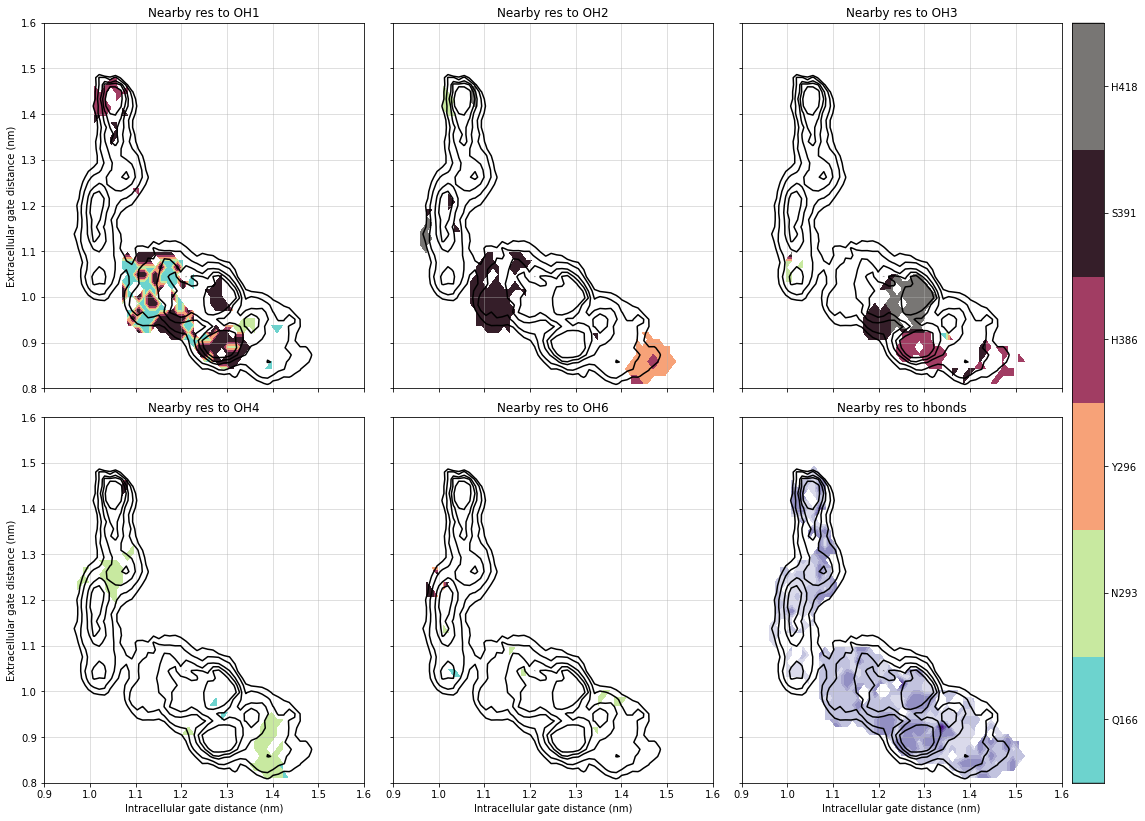

In [29]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(19, 15))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,3),
                 axes_pad=0.4,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )

color_l = ['#6DD3CE', '#C8E9A0', '#F7A278', '#A13D63', '#351E29', '#787674']
levels = np.arange(0, max(hbond_score_dict.values())+1) #MUST START AT 0 DO NOT CHANGE!!!!!!!!!!!!!!
for n,ax in enumerate(grid):
    if oh_group_names[n] != 'all_hbonds':
        dist_contour = ax.contourf(all_OH_contacts[n], extent = extent, \
                                    colors = color_l, levels = levels)
    
    elif oh_group_names[n] == 'all_hbonds':
        hbond_contour = ax.contourf(all_OH_contacts[n], extent = extent, \
                                    cmap=plt.cm.Purples, vmin = 0, vmax = 5)
    
    line_levels = [0, 1, 1.5, 2, 3, 4]
    FES_contour = ax.contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black')


    ax.grid(which='major', alpha=0.5)
    ax.set_xlim(0.9,1.6)
    ax.set_ylim(0.8,1.6)
    ax.set_xlabel('Intracellular gate distance (nm)')
    ax.set_ylabel('Extracellular gate distance (nm)')
    
    ax.set_title(f"Nearby res to {oh_group_names[n].split('_')[1]}")


    
# Colorbar - change labels depending on what numbers you want
cb = ax.cax.colorbar(dist_contour, ticks = levels[:-1]+0.5) #make labels in the middle
if sim_numbers:
    cb.ax.set_yticklabels([sim_to_paper_residue_nums[x] for x in hbond_score_dict.keys()])
else:
    cb.ax.set_yticklabels(hbond_score_dict.keys())


plt.savefig('../images_figs/histograms_on_FES/OH_group_hbonds.FESoverlay.png', dpi = 1000)

## plotting closest OH group for certain residues
Note that this is like the inverse of above, where we had one subplot per oh group, colored by residue. Here we will have one subplot per residue, colored by hydroxyl group

The function and the way you call the function work identical to the graph above, just flipped around

In [31]:
sig_cluster_histos = list(cluster_and_OH_info_df.index)
scoring_function_selection = 'nearby_particular_residue'

hbond_score_dict = {'nearby_OH1':1, 'nearby_OH2':2, 'nearby_OH3':3, 'nearby_OH4':4, 'nearby_OH6':5}

num = 54


all_OH_contacts = []

# I want the last piece of the graph to be all the possible h bonds
binding_site_res = ['GLN:160', 'ASN:287', 'TYR:290', 'SER:385']

for residue in binding_site_res:
    test_G = np.empty((num, num))
    test_G[:] = np.NaN


    row_index = 0
    col_index = 0
    for histo_index in sig_cluster_histos:  
        ## start over the row and cols at 55, going l --> r, bottom to top
        if histo_index % num == 0 and histo_index != 0:
            row_index = row_index + 1
            col_index = 0


        score = scoring_functions(score_choice=scoring_function_selection,
                                                    histo_index = histo_index, frames_filter=200,
                                                    hbond_score_dict=hbond_score_dict, particular_sel=residue) 

        test_G[row_index, col_index] = score
        col_index = col_index + 1

    all_OH_contacts.append(test_G)


/home/semccomas/anaconda3/envs/string_method/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


/tmp/ipykernel_5263/2373707078.py:40: MatplotlibDeprecationWarning: Since 3.2, mpl_toolkits's own colorbar implementation is deprecated; it will be removed two minor releases later.  Set the 'mpl_toolkits.legacy_colorbar' rcParam to False to use Matplotlib's default colorbar implementation and suppress this deprecation warning.
  cb = ax.cax.colorbar(dist_contour, ticks = levels[:-1]+0.5, drawedges=True) #make labels in the middle


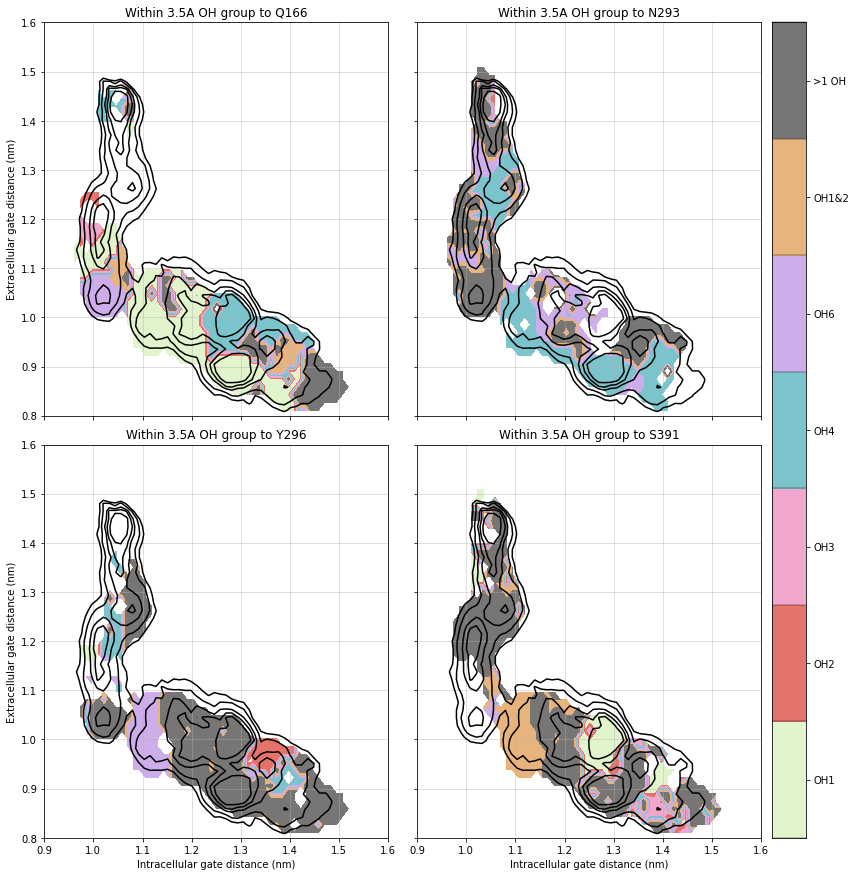

In [32]:
%matplotlib inline
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(19, 15))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,2),
                 axes_pad=0.4,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.15,
                 )

color_l = ['#e1f4cb', '#e4746a', '#F1A7CD', '#7CC4CB', '#CEAEEA', '#e8b47d', '#787674']
levels = np.arange(0, 8) #MUST START AT 0 DO NOT CHANGE!!!!!!!!!!!!!!
for n,ax in enumerate(grid):
    dist_contour = ax.contourf(all_OH_contacts[n], extent = extent, \
                                    colors = color_l, levels = levels)
    
    line_levels = [0, 1, 1.5, 2, 3, 4]
    FES_contour = ax.contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black')


    ax.grid(which='major', alpha=0.5)
    ax.set_xlim(0.9,1.6)
    ax.set_ylim(0.8,1.6)
    ax.set_xlabel('Intracellular gate distance (nm)')
    ax.set_ylabel('Extracellular gate distance (nm)')
    
    if sim_numbers:
        ax.set_title(f"Within 3.5A OH group to {sim_to_paper_residue_nums[binding_site_res[n]]}")
    else:
        ax.set_title(f"Within 3.5A OH group to {binding_site_res[n]}")


    
# Colorbar
cb = ax.cax.colorbar(dist_contour, ticks = levels[:-1]+0.5, drawedges=True) #make labels in the middle
cb.ax.set_yticklabels(['OH1', 'OH2', 'OH3', 'OH4', 'OH6', 'OH1&2', '>1 OH'])

plt.savefig('../images_figs/histograms_on_FES/binding_site_res.colorbyOH.FESoverlay.png', dpi = 1000)

In [15]:
pd.set_option('display.max_rows', None)

#cluster_and_OH_info_df.loc[:,['nearby_OH1', 'nearby_OH2', 'nearby_OH3', 'nearby_OH4', 'nearby_OH6']]

## Plot 'score' based on how frequent does a cluster occur, plus the number of hbonds that come with this cluster

In [16]:
sig_cluster_histos = list(cluster_and_OH_info_df.index)
scoring_function_selection = 'hbond_only'

num = 54
test_G = np.empty((num, num))
test_G[:] = np.NaN


row_index = 0
col_index = 0

for histo_index in sig_cluster_histos:  
    ## start over the row and cols at 55, going l --> r, bottom to top
    if histo_index % num == 0 and histo_index != 0:
        row_index = row_index + 1
        col_index = 0

    score = scoring_functions(score_choice=scoring_function_selection,
                                                     histo_index = histo_index, frames_filter=200,
                                                    hbond_score_dict=None) 
    test_G[row_index, col_index] = score
    col_index = col_index + 1

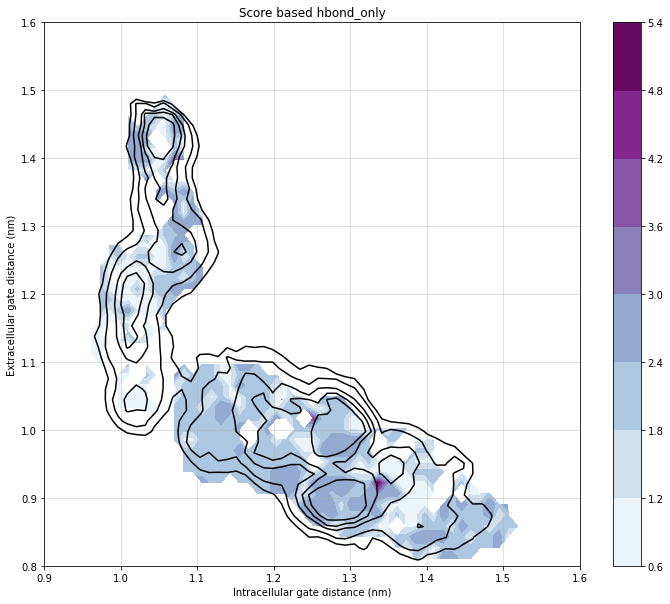

In [17]:
%matplotlib inline

f = plt.figure(figsize = (12,10))
ax = f.add_subplot(111)


color_levels = 6
score_contour = ax.contourf(test_G, extent = extent, cmap=plt.cm.BuPu, levels = color_levels)
cbar = f.colorbar(score_contour)



## contour on top of F
## you can choose what FES levels to add by changing levels below
line_levels = [0, 1, 1.5, 2, 3, 4]
FES_contour = ax.contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black')



plt.grid(which='major', alpha=0.5)
xlim = (0.9,1.6)
ylim = (0.8,1.6)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Intracellular gate distance (nm)')
plt.ylabel('Extracellular gate distance (nm)')


ax.set_title(f"Score based {scoring_function_selection}")
plt.show()

## Looking at information for transition state to put into PyMol session

In [47]:
l = [875,876,929,930]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

transition = cluster_and_OH_info_df.loc[929,'percentage_of_total']
print(transition)

[18.87 11.71 15.18 12.58 11.93 11.28  4.77  9.11  2.39  1.52  0.65]


# graveyard:

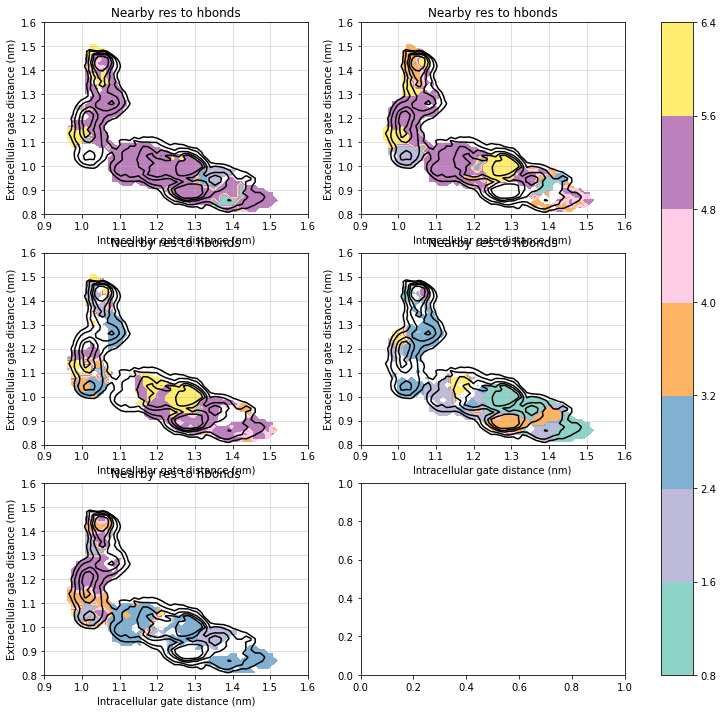

In [225]:
%matplotlib inline

fig, axes = plt.subplots(nrows = 3, ncols=2, figsize = (13,12))
axes = np.ravel(axes)

for n in range(0, len(all_OH_contacts)):
    if n <= 4:
    ## plot contour & FES
        dist_contour = axes[n].contourf(all_OH_contacts[n], extent = extent, \
                                        cmap=plt.cm.Set3, levels = 6)
        line_levels = [0, 1, 1.5, 2, 3, 4]
        FES_contour = axes[n].contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black')



        axes[n].grid(which='major', alpha=0.5)
        axes[n].set_xlim(0.9,1.6)
        axes[n].set_ylim(0.8,1.6)
        axes[n].set_xlabel('Intracellular gate distance (nm)')
        axes[n].set_ylabel('Extracellular gate distance (nm)')

        axes[n].set_title(f"Nearby res to {oh_group.split('_')[1]}")


#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.5, 0.05, 0.7])
fig.colorbar(dist_contour, ax=axes.ravel().tolist())

plt.show()

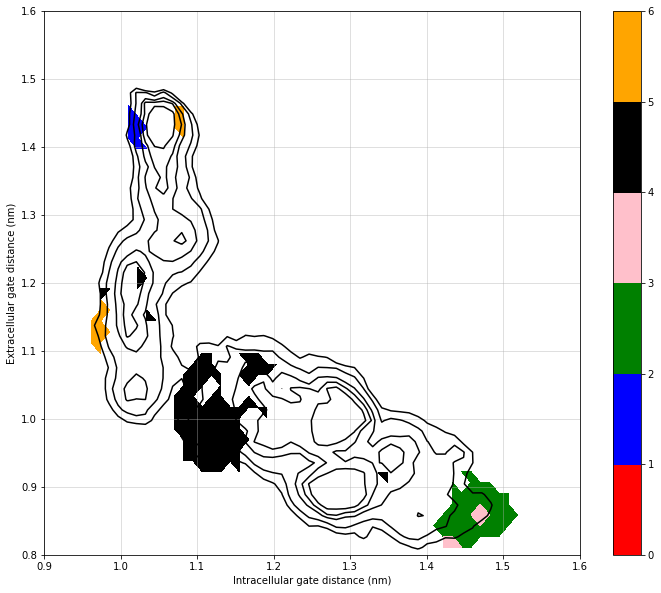

In [148]:
%matplotlib inline

f = plt.figure(figsize = (12,10))
ax = f.add_subplot(111)


score_contour = ax.contourf(test, extent = extent, colors = ('red', 'blue', 'green', 'pink', 'black', 'orange'),
                           levels = [0,1,2,3,4,5,6])
## getting the colorbar can be a bit tricky, since we want a definition for each
### defined colorbar region
## essentially mpl decides its own axis limits for the colorbar, so it's best to
## just work inside of those limits
cbar = plt.colorbar(score_contour)
# defined_ticks = list(cbar.get_ticks())
# cbar.set_ticks(np.linspace(min(defined_ticks), max(defined_ticks), color_levels))
# cbar.ax.set_yticklabels(hbond_score_dict.keys())





## contour on top of F
## you can choose what FES levels to add by changing levels below
line_levels = [0, 1, 1.5, 2, 3, 4]
FES_contour = ax.contour(F, extent = extent, levels = line_levels, vmax = 5, vmin = 0, colors = 'black')



plt.grid(which='major', alpha=0.5)
xlim = (0.9,1.6)
ylim = (0.8,1.6)
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel('Intracellular gate distance (nm)')
plt.ylabel('Extracellular gate distance (nm)')


plt.show()

In [20]:
test_G[40]

array([nan, nan, nan, nan, nan, nan,  3.,  3.,  3., nan,  1.,  2.,  1.,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [35]:
test_G[25]

array([nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0., nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan])

In [48]:
oh_group.split('_')

['hbond', 'OH4']

# old histo processing, I don't think we need but I don't want to remove just yet

If you want to, you can already filter out the 'insignificant' frames

If you don't do this, the plotting will take longer but you will get to see the calculation for every single histogram, even the empty ones

In [ ]:
#cluster_info_df = cluster_info_df.loc[cluster_info_df['total_frames'] > 300]
#cluster_info_df = cluster_info_df.mask(cluster_info_df['total_frames'] < 400, 0) #this will mask the whole row to be 0

With `feature_color` we just have to tinker with the colors a bit, but the idea would be that I can put in a number here (say 50, for max percentage out of 100), so you color in the colorbar appropriately. Hope this makes sense when I read it later, I am very tired

In [ ]:
def get_square(data, IC_leftmost, IC_rightmost, EC_lowermost, EC_uppermost, IC_index, EC_index):
    '''
    IC index should be 0 or 1 depending on where it exists in data, same for EC
    '''
    
    col0m = np.logical_and(data[:,IC_index]>= IC_leftmost, data[:,IC_index]<=IC_rightmost) #IC column mask
    col1m = np.logical_and(data[:,EC_index]>= EC_lowermost, data[:,EC_index]<=EC_uppermost) #EC column mask

    col0_1 = data[col0m & col1m]
    
    IC_selected_region = col0_1[:,IC_index]
    EC_selected_region = col0_1[:,EC_index]
    
    return IC_selected_region, EC_selected_region

In [ ]:
extent = np.load('../../string_sims/TMD_initial_path/influx_BFRU_gate_CV/extent_MSM.npy')
F = np.load('../../string_sims/TMD_initial_path/influx_BFRU_gate_CV/F_MSM.npy')
IC_extent = np.linspace(extent[0], extent[1], 55)
EC_extent = np.linspace(extent[2], extent[3], 55)
margin = np.diff(IC_extent)[0] / 2 + 0.001

def get_FES_grid_coord_from_histo_nr(histogram_number, feature_color, max_feature_color):
    
    
    #### PT 1 - copying from histogram_FES_to_confout to get approx box coordinates for histogram

    
    grid_label = 0
    grid_label_coord_dict = {}
    for y_grid_index in range(0, 55):
        for x_grid_index in range(0, 55):
            if x_grid_index < 54 and y_grid_index < 54:
                #print(x_grid_index, ':x_left', y_grid_index, ':y_bottom')
                #print(x_grid_index + 1, ':x_right', y_grid_index, ':y_bottom')
                #print(x_grid_index, ':x_left', y_grid_index + 1, ':y_top')
                #print(x_grid_index + 1, ':x_right', y_grid_index + 1, ':y_top')

                IC_leftmost = IC_extent[x_grid_index] - 0.01
                IC_rightmost = IC_extent[x_grid_index + 1] + 0.01
                EC_uppermost = EC_extent[y_grid_index + 1] + 0.01
                EC_lowermost = EC_extent[y_grid_index] - 0.01

                coords = [IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost]    
                grid_label_coord_dict[grid_label] = coords
                grid_label = grid_label + 1
   
    IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost = grid_label_coord_dict[histogram_number]            

    
    #### PT 2 - again, copying from histogram_FES_to_confout to get actual coordinates for the data we extracted
    #### I only really do it in this way because I want it to be consistent with the previous extraction
    ### The idea here is that we get the 4 box points from F (should be same as orange dots in histogram selected_regions pic)
    ### and then we will extend the box around this by half their dist + margin (see notion in sugar analysis for explanation)
    ## this should ALMOST nearly accurately reflect what IC and EC gate vals we are using. Again, see notion for why
    min_F = 0
    max_F = 15
    IC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[1]
    EC_min_indices = np.where(np.logical_and(F > min_F, F < max_F))[0]

    #Return the IC&EC gate values where F is within specified range
    IC_min_vals = []
    EC_min_vals = []
    for val_IC, val_EC in zip(IC_extent[IC_min_indices], EC_extent[EC_min_indices]):
        IC_min_vals.append(val_IC)
        EC_min_vals.append(val_EC)

    all_min_vals = np.vstack((IC_min_vals, EC_min_vals)).T


    IC_selected_region, EC_selected_region = get_square(data = all_min_vals,
                                                        IC_leftmost=IC_leftmost,
                                                        IC_rightmost=IC_rightmost,
                                                        EC_lowermost=EC_lowermost,
                                                        EC_uppermost=EC_uppermost,
                                                        IC_index=0,
                                                        EC_index=1)
    all_min_vals_selected_region = np.vstack((IC_selected_region, EC_selected_region)).T


    ### change this coloring
    colormap_colors = 'viridis'
    cmap_vals = plt.cm.get_cmap(colormap_colors)
    color_vals = cmap_vals(np.linspace(0,1,max_feature_color))


    scat = plt.scatter(np.mean([IC_leftmost, IC_rightmost]), \
            np.mean([EC_uppermost, EC_lowermost]), \
           s = 50, color = color_vals[feature_color], cmap = cmap_vals)

   # return IC_leftmost, IC_rightmost, EC_uppermost, EC_lowermost
    return scat, histogram_number, feature_color, [np.round(np.mean([IC_leftmost, IC_rightmost]),3),\
                                    np.round(np.mean([EC_uppermost, EC_lowermost]),3)], all_min_vals_selected_region

In [ ]:
scat, histogram_number, value, histo_loc, test = get_FES_grid_coord_from_histo_nr(histogram_number = 875, 
                                     feature_color= int(cluster_info_df.loc[x, 'max_percentage']),\
                                    max_feature_color= 101)

In [ ]:
ic_test = test[:,0]
ec_test = test[:,1]

ic_l = ic_test[0] - margin
ic_r = ic_test[1] + margin
ec_u = ec_test[2] + margin
ec_l = ec_test[0] - margin

print(ic_l, ic_r, ec_u, ec_l)
print(histo_loc)

print(np.mean([ic_l, ic_r]), np.mean([ec_u, ec_l]))

Now we will call the above function to plot on the graph any feature we would like

The location of this point is approximately where the histogram would fall on the FES, so we have a map of where certain features belong to on our FES

`histo_coords` will be appended to `histo_coords_all` for easy access to see where the coloring is coming from

In [ ]:
%matplotlib widget
fig = plt.figure(figsize = (12,8))

sig_cluster_histos = list(cluster_info_df.index)

histo_vals_all = {}
for x in sig_cluster_histos:
    scat, histogram_number, value, histo_loc = get_FES_grid_coord_from_histo_nr(histogram_number = x, 
                                     feature_color= int(cluster_info_df.loc[x, 'max_percentage']),\
                                    max_feature_color= 101)
    histo_vals_all[histogram_number] = [value, histo_loc[0], histo_loc[1]]
xlim = (0.9,1.6)
ylim = (0.8,1.6)


plt.grid(which='major', alpha=0.5)

# choose how many ticks you want on colorbar, then label them how you need
cbar = fig.colorbar(scat, ticks = [0, 0.25, 0.5, 0.75, 1])
cbar.ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])

plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [ ]:
#cluster_info_df

We are trying out contour plots. This website is very helpful: https://alex.miller.im/posts/contour-plots-in-python-matplotlib-x-y-z/

I am printing out `Z` just so we can see what this `pivot_table` does

In [ ]:
%matplotlib widget
contour_data = pd.DataFrame.from_dict(histo_vals_all, orient = 'index')
contour_data = contour_data.rename(columns = {0:'Z', 1:'X', 2:'Y'})

X_unique = np.sort(contour_data.X.unique())
Y_unique = np.sort(contour_data.Y.unique())
X, Y = np.meshgrid(X_unique, Y_unique)

Z = contour_data.pivot_table(index='X', columns='Y', values='Z').T.values
#print(pd.DataFrame(X))



## figure init
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)




# Generate a contour plot
levels = np.array([0,25,50,75,100])
cpf = ax.contourf(X,Y,Z, len(levels), cmap=plt.cm.Reds)
line_colors = ['black' for l in cpf.levels]
cp = ax.contour(X, Y, Z, levels=levels, colors=line_colors)


## colorbar & grid
cbar = fig.colorbar(cpf, ticks = [0, 25, 50, 75, 100])
cbar.ax.set_yticklabels(['0%', '25%', '50%', '75%', '100%'])
plt.grid(which='major', alpha=0.5)

## other feats
xlim = (0.9,1.6)
ylim = (0.8,1.6)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [ ]:
contour_data